Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [1]:
FN = 'vocabulary-embedding'

In [2]:
seed=42

In [3]:
vocab_size = 40000

In [4]:
embedding_dim = 100

In [5]:
lower = False # dont lower case the text

# read tokenized headlines and descriptions

In [6]:
import pickle
FN0 = 'tokens'
with open('data/%s.pkl'%FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [7]:
if lower:
    heads = [h.lower() for h in heads]

In [8]:
if lower:
    desc = [h.lower() for h in desc]

In [9]:
i=0
heads[i]

'Lyft riders will be able to hail a semi-autonomous car by the end of 2017'

In [10]:
desc[i]

'Lyft riders will be able to hail a semi-autonomous car in the Bay Area by the end of 2017\n\nLyft is adding another self-driving startup to the roster of software companies it’s working with. The ride-hail company will be working with Drive.ai to bring its semi-autonomous cars to the Bay Area by the end of the year.\n\nLyft riders will be able to summon a car that drives itself part of the time. A driver will still be present to take over in situations where the software can’t properly read the terrain or the presence of pedestrians.\n\nWhile the experience won’t be significantly different to the customer, Lyft and its chief competitor, Uber, have been testing semi-autonomous vehicles in an effort to eventually deploy cars without drivers. Such vehicles could operate nearly continuously, and wouldn’t require the company to split fares with the driver.\n\nDrive.ai, which recently raised $50 million and is backed by GGV Capital, is now the fourth autonomous software company Lyft has sig

In [11]:
len(heads),len(set(heads))

(281, 278)

In [12]:
len(desc),len(set(desc))

(281, 233)

# build vocabulary

In [13]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [14]:
vocab, vocabcount = get_vocab(heads+desc)

In [15]:
#vocab_size = vocabcount

most popular tokens

In [16]:
print (vocab[:50])
print ('...',len(vocab))

['the', 'to', 'of', 'a', 'and', 'in', 'is', 'that', 'for', 'on', 'be', 'with', 'as', 'The', 'I', 'it', 'are', 'an', 'was', 'or', 'have', 'by', 'not', 'this', 'from', 'you', 'we', 'at', 'can', 'has', 'will', 'they', 'their', 'which', 'more', 'but', 'about', 'all', 'one', 'would', 'its', 'had', 'he', 'were', 'my', 'like', 'also', 'your', 'than', 'In']
... 36722


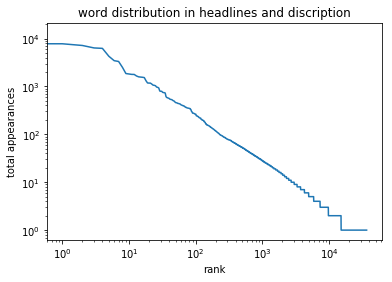

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [18]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [19]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [20]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [21]:
import os
import urllib.request as urllib

In [22]:
fname = 'glove.6B.%dd.txt'%embedding_dim
datadir_base = os.getcwd()
datadir = os.path.join(datadir_base, 'data')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'    
    response = urllib.urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", datadir+"/"+path)
    !unzip {datadir}/{path}
    

In [23]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [24]:
import numpy as np

In [25]:
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [26]:
glove_embedding_weights.std()

0.040815727600190289

In [27]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

In [28]:
idx2word[36723]

'Capital'

use GloVe to initialize embedding matrix

In [29]:
vocab_size = max([key for key, values in idx2word.items()])

In [30]:
import numpy as np

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
#print ('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    #print(i)
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print ('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

number of tokens, in small vocab, found in glove and copied to embedding 18338 0.49936007406802274


In [31]:
idx2word[0]

'<empty>'

lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [32]:
glove_thr = 0.5

In [33]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [34]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print ('# of glove substitutes found', len(glove_match))

# of glove substitutes found 47


manually check that the worst substitutions we are going to do are good enough

In [35]:
for orig, sub, score in glove_match[-10:]:
    print (score, orig,'=>', idx2word[sub])

0.590426410821 Wirtschaftswunder => Sandmann
0.589314376718 ruthlessly => relentlessly
0.587278356438 hazy => dreary
0.579566602396 Caspar => Friedrich
0.573253022795 rightfully => obligated
0.572478695442 captive => captured
0.565235633007 Kaiser => Ernst
0.564540639312 à => et
0.548086652502 backward => sliding
0.542630236136 Historisches => Sandmann


build a lookup table of index of outside words to index of inside words

In [36]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [37]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

281

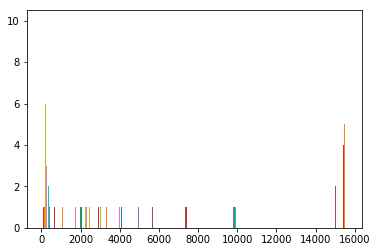

In [39]:
plt.hist(Y,bins=50);

In [40]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

281

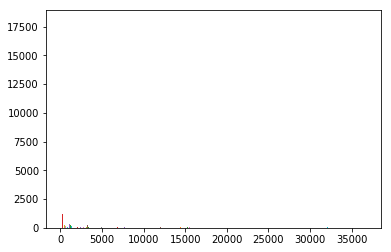

In [41]:
plt.hist(X,bins=50);

In [42]:
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [43]:
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)